In [23]:
################################################################################
#   Copyright (c) 2022 LASSE
#
#   This program is free software; you can redistribute it and/or modify
#   it under the terms of the GNU General Public License version 3 as
#   published by the Free Software Foundation;
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program; if not, write to the Free Software
#   Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA  02111-1307  USA
################################################################################
# Based on Public Domain code written by LASSE: Ailton Oliveira, Aldebaro Klautau, Arthur Nascimento, Diego Gomes, Jamelly Ferreira, João Borges, Luan Gonçalves, and Walter Frazão.

"""Trains a deep NN for choosing top-K beams
Adapted by AK: Aug 7, 2018
See
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
and
https://stackoverflow.com/questions/45642077/do-i-need-to-use-one-hot-encoding-if-my-output-variable-is-binary
See for explanation about convnet and filters:
https://datascience.stackexchange.com/questions/16463/what-is-are-the-default-filters-used-by-keras-convolution2d
and
http://cs231n.github.io/convolutional-networks/
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, \
    Flatten, MaxPooling2D, Dense, Input, Dropout, ReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from scipy.special import softmax

%matplotlib inline

In [4]:
class ModelHandler:
    def createArchitecture(self,num_classes,input_shape):
        '''
        Returns a NN model.
        numClasses: a scalar which denotes the number of classes to be predicted
        input_shape: a tuple with the dimensions of the input of the model
        '''
        dropProb=0.3
        input_lid = Input(shape = input_shape)
                    
        layer = Conv2D(10,kernel_size=(13,13),
                            activation='relu',
                            padding="SAME",
                            input_shape=input_shape)(input_lid)
        layer = Conv2D(30, (11, 11), padding="SAME", activation='relu')(layer)
        layer = Conv2D(25, (9, 9), padding="SAME", activation='relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 1))(layer)
        layer = Dropout(dropProb)(layer)
        layer = Conv2D(20, (7, 7), padding="SAME", activation='relu')(layer)
        layer = MaxPooling2D(pool_size=(1, 2))(layer)
        layer = Conv2D(15, (5, 5), padding="SAME", activation='relu')(layer)
        layer = Dropout(dropProb)(layer)
        layer = Conv2D(10, (3, 3), padding="SAME", activation='relu')(layer)
        layer = Conv2D(1, (1, 1), padding="SAME", activation='relu')(layer)
        layer = Flatten()(layer)
        out = Dense(num_classes,activation='softmax')(layer)
        
        architecture = Model(inputs = input_lid, outputs = out)
        
        return architecture

    def build_resblock(self, input_shape, nChannels, maxpooling=True):
        input = Input(shape=input_shape)
        x = Conv2D(nChannels, (3, 3), padding="same", activation="relu")(input)
        x = Conv2D(nChannels, (3, 3), padding="same", activation=None)(x)
        x = input + x
        x = ReLU()(x)
        if maxpooling:
            x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
        return Model(inputs=input, outputs=x)


In [5]:
###############################################################################
# Support functions
###############################################################################

# For description about top-k, including the explanation on how they treat ties (which can be misleading
# if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)
# https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k


def top_10_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)


def top_30_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=30)


def top_50_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=50)


def top_100_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=100)


def sub2ind(array_shape, rows, cols):
    ind = rows * array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0] * array_shape[1]] = -1
    return ind


def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0] * array_shape[1]] = -1
    rows = ind.astype("int") / array_shape[1]
    cols = ind % array_shape[1]
    return (rows, cols)


def beamsLogScale(y, thresholdBelowMax):
    y_shape = y.shape

    for i in range(0, y_shape[0]):
        thisOutputs = y[i, :]
        logOut = 20 * np.log10(thisOutputs + 1e-30)
        minValue = np.amax(logOut) - thresholdBelowMax
        zeroedValueIndices = logOut < minValue
        thisOutputs[zeroedValueIndices] = 0
        thisOutputs = thisOutputs / sum(thisOutputs)
        y[i, :] = thisOutputs

    return y

#converts the combined channel gains into the label vector y
#to be used for training the model. For instance, if a softmax
#activation is used in the DNN output, then make y sum up to 1.
def prepare_output_labels(original_gains):  
    method = 1 #for using DNN output with softmax activation    
    if method == 1:
        thresholdBelowMax = 60 #threshold in dB for zeroing gains in log domain
        y = log_normalize_channel_gain(original_gains,thresholdBelowMax)
    return y

#converts to log scale and make zero the values below the specified threshold
def log_normalize_channel_gain(y,thresholdBelowMax):
    num_gains = len(y)
    #print('AK',num_gains)
    for i in range(0,y.shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            #normalize to sum up to 1, and enable using softmax activation
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs        
    return y

#instead of representing the pair of beam indices with two integers, use only one integer.
#for instance, if yMatrix has a shape of (11194, 8, 32), where 8 is the number of Rx antennas
#and 32 the number of Tx antennas, then y_output has the shape (11194, 256) because 256=8*32.
#this way, a single index will indicate the pair of indices
def convert_pair_to_index(yMatrix):
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    return y, num_classes


def getBeamOutput(output_file):

    print("Reading dataset...", output_file)
    output_cache_file = np.load(output_file)
    yMatrix = output_cache_file["output_classification"]

    num_classes = 256

    pairs = [[i, j] for i in range(8) for j in range(32)]
    yMatrix = yMatrix.tolist()
    indexes = [pairs.index(yMatrix[item]) for item in range(len(yMatrix))]

    y = to_categorical(indexes, num_classes)

    return y, num_classes

In [9]:
###############################################################################
# Data configuration
###############################################################################
tf.device("/device:GPU:0")

num_epochs = 2
batch_size = 32
tgtRec = 3
seed = 0

np.random.seed(seed)

lidar_train_input_file = "./files_04_beam/lidar_input/lidar_input.npz"
lidar_train_cache_file = np.load(lidar_train_input_file)
X_lidar = lidar_train_cache_file["input"]
X_lidar_train, X_lidar_validation = train_test_split(
    X_lidar, test_size=0.2, random_state=seed, shuffle=True
)
print("Reading dataset... ", lidar_train_input_file)
lidar_train_input_shape = X_lidar_train.shape

Reading dataset...  ./files_04_beam/lidar_input/lidar_input.npz


In [11]:
###############################################################################
# Output configuration
output_file = "./files_04_beam/beam_output/beams_output.npz"

print("Reading dataset...", output_file)
output_cache_file = np.load(output_file)
yMatrix = output_cache_file['output_classification']
y_output, num_classes = convert_pair_to_index(yMatrix)
y = prepare_output_labels(y_output)

(
    X_lidar_train,
    X_lidar_validation,
    y_train,
    y_validation,
) = train_test_split(
    X_lidar, y_output, test_size=0.2, random_state=seed, shuffle=True
)

Reading dataset... ./files_04_beam/beam_output/beams_output.npz


In [12]:
##############################################################################
# Model configuration
##############################################################################

modelHand = ModelHandler()
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam",
)

model = modelHand.createArchitecture(
    num_classes,
    [
        lidar_train_input_shape[1],
        lidar_train_input_shape[2],
        lidar_train_input_shape[3],
    ],
)

model.compile(
    loss=categorical_crossentropy,
    optimizer=opt,
    metrics=[
        metrics.categorical_accuracy,
        metrics.top_k_categorical_accuracy,
        top_10_accuracy,
        top_30_accuracy,
        top_50_accuracy,
        top_100_accuracy,
    ],
)
model.summary()
hist = model.fit(
    X_lidar_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_lidar_validation, y_validation),
)

# with open("history.txt", "w") as f:
#     f.write(str(hist.history))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 200, 10)]     0         
                                                                 
 conv2d (Conv2D)             (None, 20, 200, 10)       16910     
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 200, 30)       36330     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 200, 25)       60775     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 200, 25)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 200, 25)       0         
                                                             

2022-09-19 14:42:53.001608: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358200000 exceeds 10% of free system memory.


Epoch 1/2
280/280 [==============================] - 500s 2s/step - loss: 4.8531 - categorical_accuracy: 0.2338 - top_k_categorical_accuracy: 0.5905 - top_10_accuracy: 0.7347 - top_30_accuracy: 0.9166 - top_50_accuracy: 0.9578 - top_100_accuracy: 0.9841 - val_loss: 4.7640 - val_categorical_accuracy: 0.3180 - val_top_k_categorical_accuracy: 0.6811 - val_top_10_accuracy: 0.7865 - val_top_30_accuracy: 0.9415 - val_top_50_accuracy: 0.9678 - val_top_100_accuracy: 0.9906
Epoch 2/2
280/280 [==============================] - 506s 2s/step - loss: 4.7260 - categorical_accuracy: 0.3170 - top_k_categorical_accuracy: 0.7178 - top_10_accuracy: 0.8332 - top_30_accuracy: 0.9491 - top_50_accuracy: 0.9725 - top_100_accuracy: 0.9908 - val_loss: 4.7003 - val_categorical_accuracy: 0.3341 - val_top_k_categorical_accuracy: 0.7441 - val_top_10_accuracy: 0.8499 - val_top_30_accuracy: 0.9540 - val_top_50_accuracy: 0.9741 - val_top_100_accuracy: 0.9902


In [13]:
"""##Baselines cores"""

beam_weights = {}
for i in range(y_train.shape[1]):
    beam_weights[i] = 0

for i in range(y_train.shape[0]):
    scene_array = y_train[i, :]
    beam_weights[np.argmax(scene_array)] += 1

ocurrence = np.zeros((1, y_validation.shape[1]))
oc_factor = sum(beam_weights.values())
for b_index in beam_weights.keys():
    ocurrence[0, b_index] = beam_weights[b_index] / oc_factor

# ocurrence
ocurrence_input = np.repeat(ocurrence, y_validation.shape[0], axis=0)
ocurrence_output = softmax(ocurrence_input, axis=1)
# rand
rand_input = np.random.rand(X_lidar_validation.shape[0], 256)
rand_output = softmax(rand_input, axis=1)


Text(0.5, 1.0, 'LIDAR data')

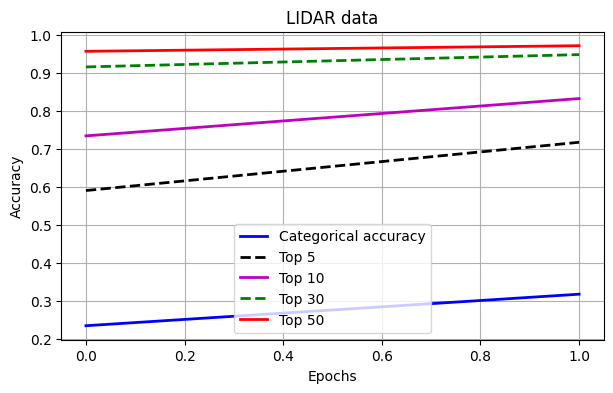

In [14]:
"""#Accuracy / epochs"""

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(
    hist.history["categorical_accuracy"], "b", label="Categorical accuracy", linewidth=2
)
ax.plot(hist.history["top_k_categorical_accuracy"], "k--", label="Top 5", linewidth=2)
ax.plot(hist.history["top_10_accuracy"], "m", label="Top 10", linewidth=2)
ax.plot(hist.history["top_30_accuracy"], "g--", label="Top 30", linewidth=2)
ax.plot(hist.history["top_50_accuracy"], "r", label="Top 50", linewidth=2)
ax.set(xlabel="Epochs", ylabel="Accuracy")
ax.grid()
plt.legend()
plt.title('LIDAR data')

In [30]:
ocurrence_output = np.float32(ocurrence_output)

In [35]:
rand_output = np.float32(rand_output)

In [36]:
"""##Creating Baselines"""

predict_top_k = {}
ocurrence_top_k = {}
random_top_k = {}
y_predict = model.predict(X_lidar_validation)
for i in range(1, 51):
    predict_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, y_predict, k=i))
        / y_predict.shape[0]
    )
    ocurrence_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, ocurrence_output, k=i))
        / y_predict.shape[0]
    )
    random_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, rand_output, k=i))
        / y_predict.shape[0]
    )

70/70 [==============================] - 17s 242ms/step


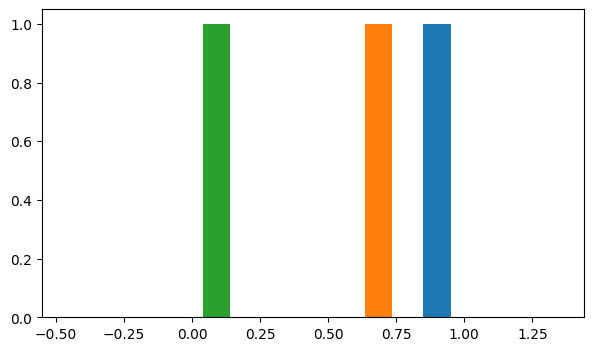

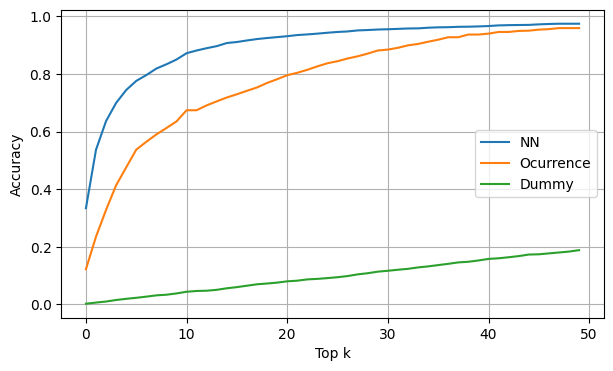

In [37]:
"""## TOP 10 acurracy"""

plt.figure(figsize=(7, 4))
plt.hist(predict_top_k["top_10"])
plt.hist(ocurrence_top_k["top_10"])
plt.hist(random_top_k["top_10"])

plt.figure(figsize=(7, 4))
plt.xlabel("Top k")
plt.ylabel("Accuracy")
plt.plot(list(predict_top_k.values()), label="NN")
plt.plot(list(ocurrence_top_k.values()), label="Ocurrence")
plt.plot(list(random_top_k.values()), label="Dummy")
plt.grid()
plt.legend()